# Set up wind farm run

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
#CONFIGSCRIPT='./baseline.py' 
CONFIGSCRIPT = os.getenv('CONFIGSCRIPT')

if (CONFIGSCRIPT is not None) and os.path.exists(CONFIGSCRIPT):
    with open(CONFIGSCRIPT) as f: 
        print(f.read())
    exec((open(CONFIGSCRIPT).read()))
else:
    # Define some properties
    CASETAG='baseline'
    rotorD = 240           # Rotor diameter
    WS     = 6.52          # Wind speed, m/s
    # Location of farm run dir
    farmrundir       = f'./rundir_{CASETAG}'
    OFoptions=("ADparam_TwrAero:True ADparam_TwrShadow:0 FSTparam_CompHydro:0 FSTparam_CompSub:0 "
               "ADparam_OutList0:RtAeroFxh "
               "EDparam_YawDOF:False "
               "EDparam_PtfmSgDOF:False "
               "EDparam_PtfmSwDOF:False "
               "EDparam_PtfmHvDOF:False "
               "EDparam_PtfmRDOF:False "
               "EDparam_PtfmPDOF:False "
               "EDparam_PtfmYDOF:False "
               "AMRparam_Actuator_epsilon:[2;2;2] "
               "AMRparam_Actuator_epsilon_tower:[2;2;2] "
               "AMRparam_Actuator_openfast_stop_time:2000.0 "
              )
    DISCON2p8_options = ("SDparam_DLL_FileName:/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so "
                         "SDparam_DLL_InFile:IEA-15-240-RWT-Monopile_DISCON.IN "
                        )

    St         = 0.3
    AWC_freq   = St*WS/rotorD
    AWC_amp    = 1.0
    AWCoptions = ("SD_param_Ptch_Cntrl:1 "
                  "DISCONparam_AWC_Mode:1 "
                  "DISCONparam_AWC_NumModes:1 DISCONparam_AWC_n:0 DISCONparam_AWC_freq:%f DISCONparam_AWC_amp:%f "%(AWC_freq, AWC_amp)
                 )
    NAWCTURBS = 0

# Define some properties
CASETAG='WS_m10'
# Location of farm run dir
farmrundir       = f'./rundir_{CASETAG}'

rotorD = 240           # Rotor diameter
WS     = 6.52          # Wind speed, m/s
OFoptions=("ADparam_TwrAero:True ADparam_TwrShadow:0 FSTparam_CompHydro:0 FSTparam_CompSub:0 "
           "FSTparam_DT_Out:0.02 "
               "ADparam_OutList0:RtAeroFxh "
               "EDparam_YawDOF:False "
               "EDparam_PtfmSgDOF:False "
               "EDparam_PtfmSwDOF:False "
               "EDparam_PtfmHvDOF:False "
               "EDparam_PtfmRDOF:False "
               "EDparam_PtfmPDOF:False "
               "EDparam_PtfmYDOF:False "
           "EDparam_RotSpeed:6.00 "
           "EDparam_NacYaw:-10.00 "
               "AMRparam_Actuator_epsilon:[2;2;2] "
               "AMRparam_Actuator_epsilon_tower:[2;2;2] "
               "AMRparam_Actuator_openfast_stop_time:2000.0 "
              )
DISCON2p8_options = ("SDparam_DLL_FileName:/lustre/orion/cfd162/proj-shared/lcheung/R

In [3]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [4]:
# Location of precursor run with boundary data
precursordir  = '/lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/precursors/LowWS_LowTI_7x2'
precursorsetup= precursordir+'/OffshorePrecursor_Stable.inp'


outputfile       = 'LowWS_LowTI_farmrun1.inp'
noturboutputfile = 'LowWS_LowTI_farmrun1_noturbs.inp'

verbose          = True
cwd              = os.getcwd()

# Go to the run directory
if os.path.exists(farmrundir):
    shutil.rmtree(farmrundir)

os.makedirs(farmrundir)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [5]:
#tstart = 26000 #chk65000 16125
#tstop  = tstart+900
#textra = 500
tstop  = 18500

In [6]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop)
case.setAMRWindInput('time.fixed_dt', 0.02)
case.setAMRWindInput('time.max_step',  -1)

In [7]:
# Set the restart point
chkdir = precursordir+'/chk35000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [8]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics35000.nc'
#tavg        =  [tstart, tstop]
tavg        = [20000, 21000]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['xlo'] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_data'

In [9]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/precursors/LowWS_LowTI_7x2/bndry_data'
SET ABL_bndry_planes = ['xlo']
SET is_periodicx = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.2456
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [8.953745472521657e-05, 0.0007193915506507243, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 35000


In [10]:
## To specify changes to the OpenFAST model
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0,     2280, 1000, IEA15MW_ALM, 270.0, , {OFoptions}
#T1,     3720, 1000, IEA15MW_ALM, 270.0, , {OFoptions}
""".format(OFoptions=turboptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [11]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/AdvancedControlsWakes/turbinemodels/OpenFAST3p5_IEA15MW to T0_OpenFAST3p5_IEA15MW
T0_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
MISMATCH between incflo.density = 1.245600 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 2000.0
OrderedDict([('CompHydro', 0), ('CompSub', 0), ('DT_Out', 0.02)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0), ('OutList0', 'RtAeroFxh')])
OrderedDict([('DLL_FileName', '/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so'), ('DLL_InFile', 'IEA-15-240-RWT-Monopile_DISCON.IN')])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False'), ('RotSpeed', 6.0), ('NacYaw', -10.0)])


    1.2456 AirDens - Air density (kg/m^3) [EDITED]
         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
      0.02 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
Adding 'RtAeroFxh' to OutList
/lustre/orion/cfd162/proj-shared/lcheung/ROSCO_2.8/ROSCO/build/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed Interface] [EDITED]
IEA-15-240-RWT-Monopile_DISCON.IN DLL_InFile - Name of input file sent to the DLL (-) [used only with Bladed Interface] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSg

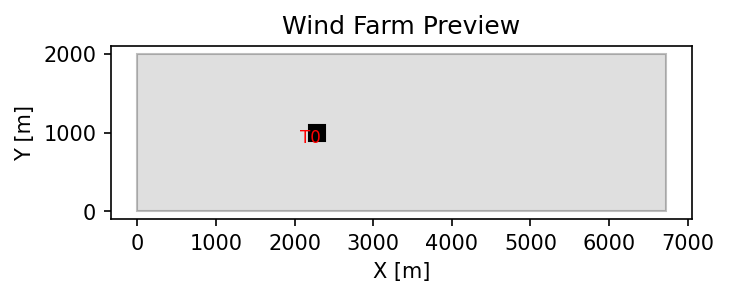

In [12]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

## Make refinement regions

In [13]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,      7,        9,         2.5,       0.80,     2,     center:farm
#1,     1.0,      1.0,        1.00,   0.80,   1.0,  
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [14]:
case.refine_createAllZones()
# Print out existing list of refinement zones
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['Farm_level_0_zone']


In [15]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0    103219200                5.0 x 5.0 x 5.0
       1    198180864                2.5 x 2.5 x 2.5
  TOTAL:    301400064


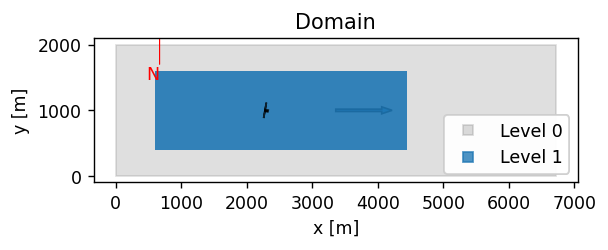

In [16]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax2)

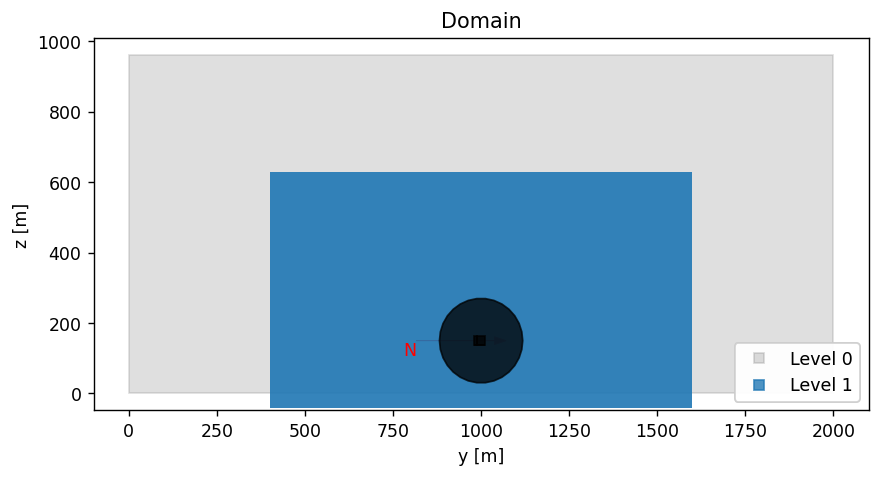

In [17]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

## Add sampling planes

In [18]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()
print(case.listboxpopupwindict['listboxsampling'].getitemlist())
print(case.listboxpopupwindict['listboxpostprosetup'].getitemlist())

[]
[]


In [19]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:25"

turbsamplingcsv = """
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,                  type,       upstream, downstream, lateral, below, above, n1, n2, options
YZdomain,              rotorplane, 5,        13,         2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZcoarse_   orientation:nacdir outputvars:velocity noffsets:9  {outputoptions}
XZdomain_coarse,       streamwise, 5,        13,         0,       0.625, 3.0,     11, 11, usedx:0.1   outputto:XZdomaincoarse_ orientation:nacdir  center:farm wholedomain:1 {outputoptions}
XYdomain_coarse,       hubheight,  5,        13,         4,       0,     1.5,     11, 11, usedx:0.1   outputto:XYdomaincoarse_ orientation:nacdir center:farm wholedomain:1  {outputoptions} noffsets:1
XY,                    hubheight,  5,        13,         2,       0.5,   1.5,     11, 11, usedx:0.025  outputto:XY_ orientation:nacdir {outputoptions} noffsets:4
XZ,                    streamwise, 5,        13,         0,       0.625, 1.5,     11, 11, usedx:0.025  outputto:XZ_  orientation:nacdir {outputoptions}
XZr,                   streamwise, 5,        13,         2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:XZ_  orientation:nacdir {outputoptions} noffsets:4
XZl,                   streamwise, 5,        13,        -2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:XZ_  orientation:nacdir {outputoptions} noffsets:4
YZ_inflow1,            rotorplane, 5,        -2,         2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZinflow_   orientation:nacdir outputvars:velocity noffsets:3  {outputoptions}
YZ_inflow2,            rotorplane, 1.5,      -1,         2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZinflow_   orientation:nacdir outputvars:velocity noffsets:1  {outputoptions}
YZ_inflow3,            rotorplane, 0.75,     -0.25,      2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZinflow_   orientation:nacdir outputvars:velocity noffsets:2  {outputoptions}
YZ_inflow4,            rotorplane, 0.1,      -0.1,       2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZinflow_   orientation:nacdir outputvars:velocity noffsets:1  {outputoptions}
YZ_wake1,              rotorplane, -0.1,     0.1,        2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZwake_   orientation:nacdir outputvars:velocity noffsets:1  {outputoptions}
YZ_wake2,              rotorplane, -0.25,    1.5,        2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZwake_   orientation:nacdir outputvars:velocity noffsets:5  {outputoptions}
YZ_wake3,              rotorplane, -2,       4,          2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZwake_   orientation:nacdir outputvars:velocity noffsets:4  {outputoptions}
YZ_wake4,              rotorplane, -5,       13,         2,       0.625, 1.5,     11, 11, usedx:0.025  outputto:YZwake_   orientation:nacdir outputvars:velocity noffsets:8  {outputoptions}
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', turbsamplingcsv)

case.setAMRWindInput('sampling_deleteprev', True)

In [20]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['T0_YZdomain', 'Farm_XZdomain_coarse', 'Farm_XYdomain_coarse', 'T0_XY', 'T0_XZ', 'T0_XZr', 'T0_XZl', 'T0_YZ_inflow1', 'T0_YZ_inflow2', 'T0_YZ_inflow3', 'T0_YZ_inflow4', 'T0_YZ_wake1', 'T0_YZ_wake2', 'T0_YZ_wake3', 'T0_YZ_wake4']


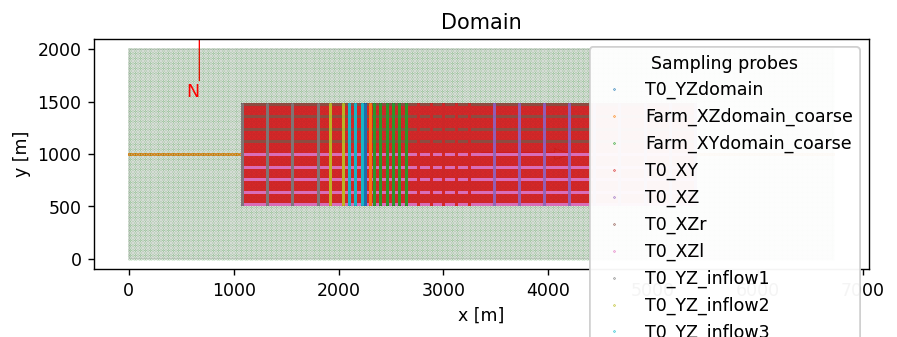

In [21]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None'}"
case.plotDomain(ax=ax)

In [22]:
case.validate();

-- Checking inputs --
[ PASS] max_level:           max_level = 1 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] restart dir:         Restart directory /lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/precursors/LowWS_LowTI_7x2/chk35000 exists
[ PASS] boundary plane dir:  Restart directory /lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/precursors/LowWS_LowTI_7x2/bndry_data exists
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ PASS] Actuator FST:T0      [T0_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst] exists
[ PASS] Actuator FST:T0      Actuator density=1.245600, matches incflo.density=1.245600
[ PASS] Actuator FST:T0      CompInflow OK
[ PASS] Actuator FST:T0      [T0_OpenFAST3p5_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile_AeroDyn15.dat] exists
[ PASS] Actuator FST:T0      WakeMod=0 OK
[ PASS] Actuator FST:T0      AirDens=1.245600, matches incflo.density=1.245600
[ SK

## Print the input file

In [23]:
# Write the input file
inputfile=case.writeAMRWindInput(outputfile)
if verbose: print(inputfile)

# --- Simulation time control parameters ---
time.stop_time                           = 18500.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.02                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 2500                
time.checkpoint_start                    = 35000               
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = /lustre/orion/cfd162/world-shared/lcheung/ALCC_Frontier_WindFarm/precursors/LowWS_LowTI_7x2/chk35000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.mode

### Create a version without turbines

In [24]:
#os.chdir(cwd)
case.removeturbines()
inputfile=case.writeAMRWindInput(noturboutputfile)
#if verbose: print(inputfile)